In [71]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import StepLR

# Define learning parameters

In [72]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [73]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.


# Generator

In [74]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [75]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [76]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [77]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

lr_decay_step = 25
lr_decay_gamma = 0.7

sche_g = StepLR(optim_g, step_size= lr_decay_step, gamma= lr_decay_gamma)
sche_d = StepLR(optim_d, step_size= lr_decay_step, gamma = lr_decay_gamma)

In [78]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [79]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [80]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# to create soft real labels (1s)
def label_real_soft(size, smooth = 0.2):
    data = torch.empty(size, 1).uniform_(1 - smooth, 1)
    return data.to(device)
# to create soft fake labels (0s)
def label_fake_soft(size, smooth = 0.2):
    data = torch.empty(size, 1).uniform_(0, smooth)
    return data.to(device)

def should_swap(probability = 0.1):
    return random.random() < probability

In [81]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [82]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [83]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [01:24,  1.39it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


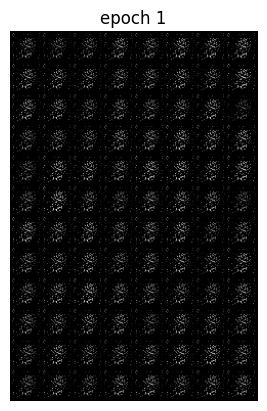

Epoch 1 of 100
Generator loss: 0.90349959, Discriminator loss: 1.29022384


118it [01:26,  1.37it/s]                         


Epoch 2 of 100
Generator loss: 1.34212361, Discriminator loss: 1.16862972


118it [01:25,  1.38it/s]                         


Epoch 3 of 100
Generator loss: 1.54219708, Discriminator loss: 1.33286073


118it [01:43,  1.14it/s]                         


Epoch 4 of 100
Generator loss: 1.53816357, Discriminator loss: 1.09829704


118it [01:28,  1.34it/s]                         


Epoch 5 of 100
Generator loss: 1.02013662, Discriminator loss: 1.25845882


118it [01:28,  1.34it/s]                         


Epoch 6 of 100
Generator loss: 1.08602694, Discriminator loss: 1.30996556


118it [01:36,  1.22it/s]                         


Epoch 7 of 100
Generator loss: 1.18043048, Discriminator loss: 1.21403592


118it [01:28,  1.33it/s]                         


Epoch 8 of 100
Generator loss: 0.97339535, Discriminator loss: 1.30128639


118it [02:07,  1.08s/it]                         


Epoch 9 of 100
Generator loss: 0.99981164, Discriminator loss: 1.26304502


118it [02:04,  1.05s/it]                         


Epoch 10 of 100
Generator loss: 1.29247697, Discriminator loss: 1.34278696


118it [01:58,  1.00s/it]                         


Epoch 11 of 100
Generator loss: 0.99235537, Discriminator loss: 1.28594275


118it [01:57,  1.01it/s]                         


Epoch 12 of 100
Generator loss: 0.90783410, Discriminator loss: 1.38907094


118it [01:34,  1.24it/s]                         


Epoch 13 of 100
Generator loss: 0.97979078, Discriminator loss: 1.23878537


118it [02:02,  1.04s/it]                         


Epoch 14 of 100
Generator loss: 1.07201335, Discriminator loss: 1.23213071


118it [01:58,  1.01s/it]                         


Epoch 15 of 100
Generator loss: 1.29173322, Discriminator loss: 1.24352742


118it [02:00,  1.02s/it]                         


Epoch 16 of 100
Generator loss: 0.92398304, Discriminator loss: 1.36774073


118it [02:00,  1.02s/it]                         


Epoch 17 of 100
Generator loss: 1.56084705, Discriminator loss: 1.22053408


118it [01:56,  1.01it/s]                         


Epoch 18 of 100
Generator loss: 1.16484189, Discriminator loss: 1.20272551


118it [01:59,  1.01s/it]                         


Epoch 19 of 100
Generator loss: 1.12919842, Discriminator loss: 1.19952192


118it [01:59,  1.01s/it]                         


Epoch 20 of 100
Generator loss: 1.23569663, Discriminator loss: 1.19774136


118it [01:57,  1.00it/s]                         


Epoch 21 of 100
Generator loss: 1.19731132, Discriminator loss: 1.17918415


118it [01:55,  1.02it/s]                         


Epoch 22 of 100
Generator loss: 1.36375007, Discriminator loss: 1.13771179


118it [01:55,  1.02it/s]                         


Epoch 23 of 100
Generator loss: 1.36000900, Discriminator loss: 1.14888924


118it [01:55,  1.02it/s]                         


Epoch 24 of 100
Generator loss: 1.04600451, Discriminator loss: 1.21882994


118it [01:56,  1.01it/s]                         


Epoch 25 of 100
Generator loss: 1.21995312, Discriminator loss: 1.16761655


118it [02:03,  1.05s/it]                         


Epoch 26 of 100
Generator loss: 1.31512519, Discriminator loss: 1.12224599


118it [01:57,  1.01it/s]                         


Epoch 27 of 100
Generator loss: 1.41031741, Discriminator loss: 1.07390031


118it [01:58,  1.00s/it]                         


Epoch 28 of 100
Generator loss: 1.36528985, Discriminator loss: 1.12977704


118it [01:43,  1.14it/s]                         


Epoch 29 of 100
Generator loss: 1.34310452, Discriminator loss: 1.12077806


118it [01:40,  1.17it/s]                         


Epoch 30 of 100
Generator loss: 1.33783336, Discriminator loss: 1.14672454


118it [01:35,  1.24it/s]                         


Epoch 31 of 100
Generator loss: 1.30002069, Discriminator loss: 1.14320176


118it [01:23,  1.42it/s]                         


Epoch 32 of 100
Generator loss: 1.32091225, Discriminator loss: 1.14222553


118it [01:20,  1.46it/s]                         


Epoch 33 of 100
Generator loss: 1.39022320, Discriminator loss: 1.10651520


118it [01:22,  1.43it/s]                         


Epoch 34 of 100
Generator loss: 1.15495052, Discriminator loss: 1.22162180


118it [01:21,  1.45it/s]                         


Epoch 35 of 100
Generator loss: 1.31088933, Discriminator loss: 1.13932853


118it [01:21,  1.44it/s]                         


Epoch 36 of 100
Generator loss: 1.26423755, Discriminator loss: 1.18979176


118it [01:20,  1.46it/s]                         


Epoch 37 of 100
Generator loss: 1.14399304, Discriminator loss: 1.22806514


118it [01:23,  1.42it/s]                         


Epoch 38 of 100
Generator loss: 1.32330496, Discriminator loss: 1.13473979


118it [01:20,  1.46it/s]                         


Epoch 39 of 100
Generator loss: 1.20742373, Discriminator loss: 1.17831789


118it [01:22,  1.43it/s]                         


Epoch 40 of 100
Generator loss: 1.38021793, Discriminator loss: 1.10256326


118it [01:23,  1.42it/s]                         


Epoch 41 of 100
Generator loss: 1.16912418, Discriminator loss: 1.23730009


118it [01:20,  1.46it/s]                         


Epoch 42 of 100
Generator loss: 1.28218865, Discriminator loss: 1.15231942


118it [01:23,  1.42it/s]                         


Epoch 43 of 100
Generator loss: 1.33252210, Discriminator loss: 1.12408365


118it [01:20,  1.46it/s]                         


Epoch 44 of 100
Generator loss: 1.31391508, Discriminator loss: 1.16094188


118it [01:21,  1.45it/s]                         


Epoch 45 of 100
Generator loss: 1.32921427, Discriminator loss: 1.16543952


118it [01:22,  1.43it/s]                         


Epoch 46 of 100
Generator loss: 1.24455678, Discriminator loss: 1.21255217


118it [01:23,  1.41it/s]                         


Epoch 47 of 100
Generator loss: 1.24627156, Discriminator loss: 1.17594776


118it [01:21,  1.46it/s]                         


Epoch 48 of 100
Generator loss: 1.37888243, Discriminator loss: 1.10324317


118it [01:21,  1.44it/s]                         


Epoch 49 of 100
Generator loss: 1.22166061, Discriminator loss: 1.22407106


118it [01:23,  1.42it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


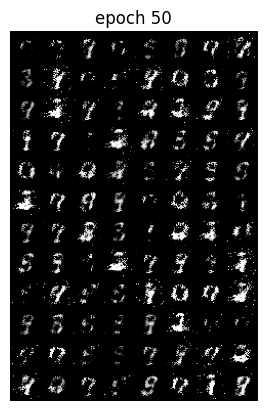

Epoch 50 of 100
Generator loss: 1.26239603, Discriminator loss: 1.15274041


118it [01:21,  1.44it/s]                         


Epoch 51 of 100
Generator loss: 1.32518418, Discriminator loss: 1.14060145


118it [01:22,  1.43it/s]                         


Epoch 52 of 100
Generator loss: 1.28385997, Discriminator loss: 1.12248497


118it [01:22,  1.44it/s]                         


Epoch 53 of 100
Generator loss: 1.12452481, Discriminator loss: 1.24689093


118it [01:23,  1.41it/s]                         


Epoch 54 of 100
Generator loss: 1.22507802, Discriminator loss: 1.12315884


118it [01:20,  1.46it/s]                         


Epoch 55 of 100
Generator loss: 1.33834457, Discriminator loss: 1.12519729


118it [01:22,  1.42it/s]                         


Epoch 56 of 100
Generator loss: 1.25316970, Discriminator loss: 1.18120214


118it [01:27,  1.35it/s]                         


Epoch 57 of 100
Generator loss: 1.23902540, Discriminator loss: 1.19739401


118it [01:28,  1.34it/s]                         


Epoch 58 of 100
Generator loss: 1.26574781, Discriminator loss: 1.15454310


118it [01:26,  1.37it/s]                         


Epoch 59 of 100
Generator loss: 1.31432915, Discriminator loss: 1.08805444


118it [01:27,  1.34it/s]                         


Epoch 60 of 100
Generator loss: 1.38588210, Discriminator loss: 1.14427886


118it [01:21,  1.44it/s]                         


Epoch 61 of 100
Generator loss: 1.19328800, Discriminator loss: 1.20077197


118it [01:22,  1.42it/s]                         


Epoch 62 of 100
Generator loss: 1.23983299, Discriminator loss: 1.22940564


118it [01:20,  1.46it/s]                         


Epoch 63 of 100
Generator loss: 1.21886330, Discriminator loss: 1.14226411


118it [01:46,  1.11it/s]                         


Epoch 64 of 100
Generator loss: 1.21752124, Discriminator loss: 1.16390061


118it [01:50,  1.07it/s]                         


Epoch 65 of 100
Generator loss: 1.30859895, Discriminator loss: 1.09539738


118it [01:54,  1.03it/s]                         


Epoch 66 of 100
Generator loss: 1.29223216, Discriminator loss: 1.19523439


118it [01:58,  1.01s/it]                         


Epoch 67 of 100
Generator loss: 1.33780868, Discriminator loss: 1.10046575


118it [01:57,  1.00it/s]                         


Epoch 68 of 100
Generator loss: 1.22529442, Discriminator loss: 1.22421628


118it [01:57,  1.00it/s]                         


Epoch 69 of 100
Generator loss: 1.24223481, Discriminator loss: 1.19546588


118it [01:56,  1.01it/s]                         


Epoch 70 of 100
Generator loss: 1.07548835, Discriminator loss: 1.21076562


118it [01:58,  1.01s/it]                         


Epoch 71 of 100
Generator loss: 1.21542410, Discriminator loss: 1.17750284


118it [01:58,  1.00s/it]                         


Epoch 72 of 100
Generator loss: 1.12479550, Discriminator loss: 1.22075451


118it [01:59,  1.01s/it]                         


Epoch 73 of 100
Generator loss: 1.29628542, Discriminator loss: 1.13508720


118it [01:40,  1.17it/s]                         


Epoch 74 of 100
Generator loss: 1.31575326, Discriminator loss: 1.12438626


118it [01:40,  1.17it/s]                         


Epoch 75 of 100
Generator loss: 1.31132286, Discriminator loss: 1.12799734


118it [01:37,  1.21it/s]                         


Epoch 76 of 100
Generator loss: 1.23824438, Discriminator loss: 1.21947145


118it [01:33,  1.27it/s]                         


Epoch 77 of 100
Generator loss: 1.28305691, Discriminator loss: 1.09401052


118it [01:20,  1.46it/s]                         


Epoch 78 of 100
Generator loss: 1.20898232, Discriminator loss: 1.21749425


118it [01:22,  1.44it/s]                         


Epoch 79 of 100
Generator loss: 1.12826210, Discriminator loss: 1.18683717


118it [01:19,  1.48it/s]                         


Epoch 80 of 100
Generator loss: 1.22602753, Discriminator loss: 1.12977128


118it [01:13,  1.60it/s]                         


Epoch 81 of 100
Generator loss: 1.20861343, Discriminator loss: 1.16769613


118it [00:56,  2.09it/s]                         


Epoch 82 of 100
Generator loss: 1.23180991, Discriminator loss: 1.14804919


118it [00:55,  2.13it/s]                         


Epoch 83 of 100
Generator loss: 1.20143777, Discriminator loss: 1.19442663


118it [00:55,  2.12it/s]                         


Epoch 84 of 100
Generator loss: 1.10065767, Discriminator loss: 1.23684837


118it [00:56,  2.09it/s]                         


Epoch 85 of 100
Generator loss: 1.16065978, Discriminator loss: 1.19817013


118it [00:55,  2.14it/s]                         


Epoch 86 of 100
Generator loss: 1.22370195, Discriminator loss: 1.17099922


118it [00:55,  2.12it/s]                         


Epoch 87 of 100
Generator loss: 1.10952480, Discriminator loss: 1.21328300


118it [00:57,  2.05it/s]                         


Epoch 88 of 100
Generator loss: 1.20739928, Discriminator loss: 1.16324564


118it [00:55,  2.14it/s]                         


Epoch 89 of 100
Generator loss: 1.07128834, Discriminator loss: 1.26470626


118it [00:55,  2.14it/s]                         


Epoch 90 of 100
Generator loss: 1.13784269, Discriminator loss: 1.17800274


118it [00:57,  2.06it/s]                         


Epoch 91 of 100
Generator loss: 1.20609090, Discriminator loss: 1.13417696


118it [00:55,  2.13it/s]                         


Epoch 92 of 100
Generator loss: 1.16085386, Discriminator loss: 1.20322016


118it [00:55,  2.13it/s]                         


Epoch 93 of 100
Generator loss: 1.23792553, Discriminator loss: 1.18029301


118it [00:55,  2.13it/s]                         


Epoch 94 of 100
Generator loss: 1.16998345, Discriminator loss: 1.19020532


118it [00:59,  1.98it/s]                         


Epoch 95 of 100
Generator loss: 1.16683327, Discriminator loss: 1.17377316


118it [00:59,  1.97it/s]                         


Epoch 96 of 100
Generator loss: 1.09356155, Discriminator loss: 1.26936090


118it [00:58,  2.02it/s]                         


Epoch 97 of 100
Generator loss: 1.02952905, Discriminator loss: 1.28335555


118it [01:00,  1.97it/s]                         


Epoch 98 of 100
Generator loss: 1.11127341, Discriminator loss: 1.19164276


118it [00:58,  2.02it/s]                         


Epoch 99 of 100
Generator loss: 1.17637865, Discriminator loss: 1.16942964


118it [00:57,  2.06it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


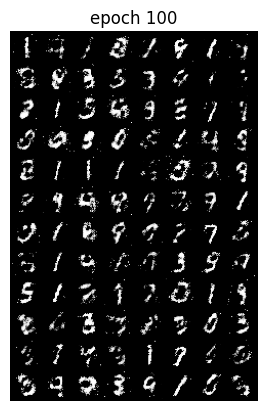

Epoch 100 of 100
Generator loss: 1.15825957, Discriminator loss: 1.24620259


In [84]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    ######################################
    
def discriminator_loss(real_output, fake_output, real_label, fake_label):
    ############ YOUR CODE HERE ##########
    return (criterion(real_output, real_label) + criterion(fake_output, fake_label))
    ######################################
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        image, _ = data #image is a tensor representation the input image 
        image = image.to(device)
        b_size = len(image)

        real_data = image.view(b_size, -1) #reshape this tensor to a 2D tensor with dimensions (batch_size, -1).
        real_label = label_real_soft(b_size)
        real_output = discriminator(real_data)

        noise = create_noise(b_size, nz)
        fake_data = generator(noise)
        fake_label = label_fake_soft(b_size)
        fake_output = discriminator(fake_data)
        if should_swap():
            real_label, fake_label = fake_label, real_label
        d_loss = discriminator_loss(real_output, fake_output, real_label, fake_label)
        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        #train generator 
        noise = create_noise(b_size, nz)
        fake_data = generator(noise)
        output = discriminator(fake_data)
        #  the negative log-likelihood of the discriminator's output for the generated fake sample being "real" 
        g_loss = generator_loss(output, label_real(b_size))
        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

        loss_g += g_loss.item()
        loss_d += d_loss.item()
        ######################################
    sche_d.step()
    sche_g.step()
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if epoch == 0 or epoch == 49 or epoch == 99:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
        
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [85]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [86]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

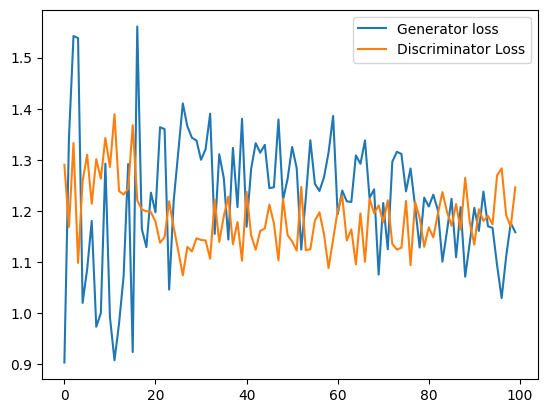

In [87]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')